<a href="https://colab.research.google.com/github/dancher00/Experimental-Data-Analysis/blob/main/4_determining_and_removing_drawbacks_of_exponential_and_running_mean_2_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from mpl_toolkits.mplot3d import Axes3D

# Assignment 4. Determining and removing drawbacks of exponential and running mean.
Task 2 <br> I. Comparison of the traditional 13-month running mean with the forward-backward exponential smoothing for approximation of 11-year sunspot cycle<br>
II. 3d surface filtration using forward-backward smoothing

Team 1:

-Alexey Kotcov: Coded second part, reviwed first.

-Roman Khalikov: Overall code,plots review and fixes, made conclusions and improved report style.

-Danil Belov: Coded first part, reviewed and improved second.

## Part 2. Comparison of the traditional 13-month running mean with the forward-backward exponential smoothing for approximation of 11-year sunspot cycle

1. Download monthly mean sunspot number from Canvas
folder ‘Files/Week_1.../Assignment4/data/Sunspot/’

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data_group1 (1).txt to data_group1 (1).txt


In [ ]:
df = pd.read_csv("data_group1 (1).txt", delimiter="\s+", header=None, names=["Year", "Month", "Monthly Mean Sunspot Number"])
df

,Year,Month,Monthly Mean Sunspot Number
0,1975,9,20.3
1,1975,10,13.6
2,1975,11,27.9
3,1975,12,11.6
4,1976,1,11.9
...,...,...,...
479,2015,8,64.4
480,2015,9,78.6
481,2015,10,61.7
482,2015,11,63.2


2. Make smoothing of monthly mean data by 13-month running mean.

Comment:
First six months in the available data are averaged to get the smoothed estimates. The same with

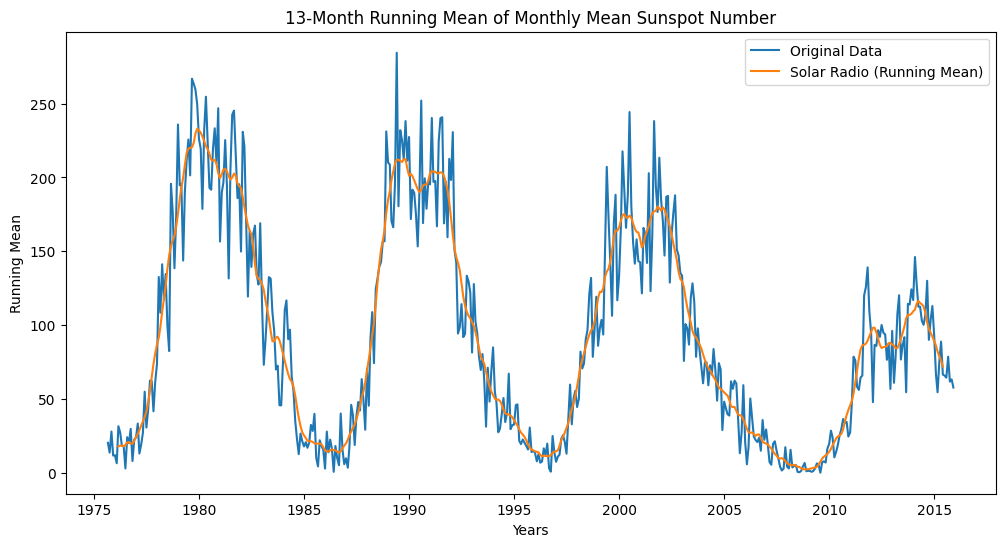

In [ ]:
df["Monthly Mean Running Mean"] = (
    1/24 * df["Monthly Mean Sunspot Number"].shift(-6)
    + 1/12 * (
        df["Monthly Mean Sunspot Number"].shift(-5)
        + df["Monthly Mean Sunspot Number"].shift(-4)
        + df["Monthly Mean Sunspot Number"].shift(-3)
        + df["Monthly Mean Sunspot Number"].shift(-2)
        + df["Monthly Mean Sunspot Number"].shift(-1)
        + df["Monthly Mean Sunspot Number"]
        + df["Monthly Mean Sunspot Number"].shift(1)
        + df["Monthly Mean Sunspot Number"].shift(2)
        + df["Monthly Mean Sunspot Number"].shift(3)
        + df["Monthly Mean Sunspot Number"].shift(4)
        + df["Monthly Mean Sunspot Number"].shift(5)
    )
    + 1/24 * df["Monthly Mean Sunspot Number"].shift(6)
)


df["Date"] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
date = df["Date"]

plt.figure(figsize=(12, 6))

plt.plot(date, df["Monthly Mean Sunspot Number"], label="Original Data")
plt.plot(date, df["Monthly Mean Running Mean"], label="Solar Radio (Running Mean)")



plt.title("13-Month Running Mean of Monthly Mean Sunspot Number")
plt.xlabel("Years")
plt.ylabel("Running Mean")
plt.legend()

plt.show()

It is the same plot we seen in Assignment 1

3. Make forward-backward exponential smoothing of monthly mean sunspot number. Is there a smoothing constant α that provides better results compared to 13-month running
mean according to deviation and variability indicators?

In [ ]:
# exponential smoothing for the measurements
def exponential_mean(z, alpha, way='forward'):
    if way not in ['forward', 'backward', 'both']:
        raise Exception('Choose proper way of exponential smoothing')

    if way == 'backward':
        z = z[::-1]
    smoothed = np.zeros_like(z)
    smoothed[0] = z[0]
    for i in range(1,len(z)):
        smoothed[i] = smoothed[i-1] + alpha * (z[i] - smoothed[i-1])
    if way == 'both':
        smoothed = exponential_mean(smoothed, alpha, way = 'backward')
    if way == 'backward':
        return smoothed[::-1]
    else:
        return smoothed

# Metrics
def deviation_indicator(z, x):
    return ((z-x)**2).sum()
def variability_indicator(x):
    return ((shift(x, -2)[:-2] - 2 * shift(x, -1)[:-2] + x[:-2])**2).sum()

alpha_values = np.arange(0.05, 1.0, 0.05)

results = {}

# Getting indicators for alphas array
for alpha in alpha_values:
    smoothed_series = exponential_mean(df["Monthly Mean Sunspot Number"].to_numpy(), alpha, 'both')
    deviation = deviation_indicator(df["Monthly Mean Sunspot Number"].to_numpy(),smoothed_series)
    variability = variability_indicator(smoothed_series)
    results[alpha] = {"Exponential mean": smoothed_series, "Deviation indicator": deviation, "Variability indicator": variability}

In [ ]:
deviation_running_mean = deviation_indicator(df["Monthly Mean Sunspot Number"],df["Monthly Mean Running Mean"])
variability_running_mean = variability_indicator(df["Monthly Mean Sunspot Number"])
print(f'Running mean deviation indicator = {deviation_running_mean}\n\
Running mean variability indicator = {variability_running_mean}')

Running mean deviation indicator = 211879.3961111111
Running mean variability indicator = 908797.1599999999


<b>NB!</b> Since we do not know nor true process nor how noisy our measurements are we cannot say which value of indicators are better for us. For further calculations let's assume that the measurements are not so noisy (so we're looking for smaller deviation indicator) but still we're trying to smooth out the data (so we're looking for smaller variability indicator)

In [ ]:
print('Alpha values which provides better(lesser) deviation indicator in comparison with running mean:')
alpha_values[[results[alpha]['Deviation indicator'] for alpha in alpha_values] < deviation_running_mean]

Alpha values which provides better(lesser) deviation indicator in comparison with running mean:


array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 , 0.85, 0.9 , 0.95])

In [ ]:
print('Alpha values which provide better(lesser) variability indicator in comparison with running mean:')
alpha_values[[results[alpha]['Variability indicator'] for alpha in alpha_values] < variability_running_mean]

Alpha values which provide better(lesser) variability indicator in comparison with running mean:


array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

To choose proper alpha value let's plot our indicators for exponential mean for alpha from 0.2 and more:

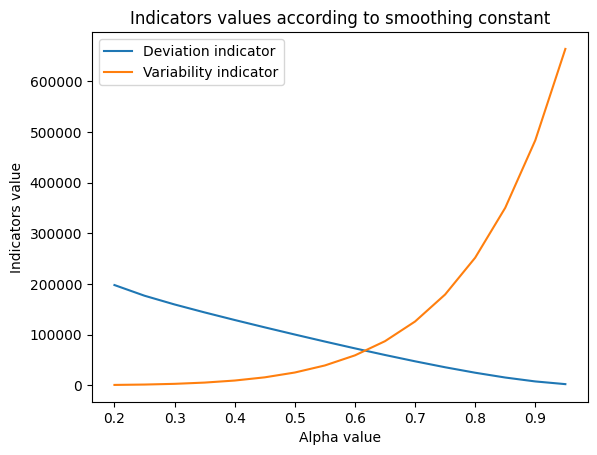

In [ ]:
alpha_values = alpha_values[[results[alpha]['Deviation indicator'] for alpha in alpha_values] < deviation_running_mean]
plt.plot(alpha_values, [results[alpha]['Deviation indicator'] for alpha in alpha_values], label = 'Deviation indicator')
plt.plot(alpha_values, [results[alpha]['Variability indicator'] for alpha in alpha_values], label = 'Variability indicator')
plt.xlabel('Alpha value')
plt.ylabel('Indicators value')
plt.title('Indicators values according to smoothing constant')
plt.legend()

According to our assumption few cells upper we can shoose alpha around 0.6 to provide the best result we're looking for

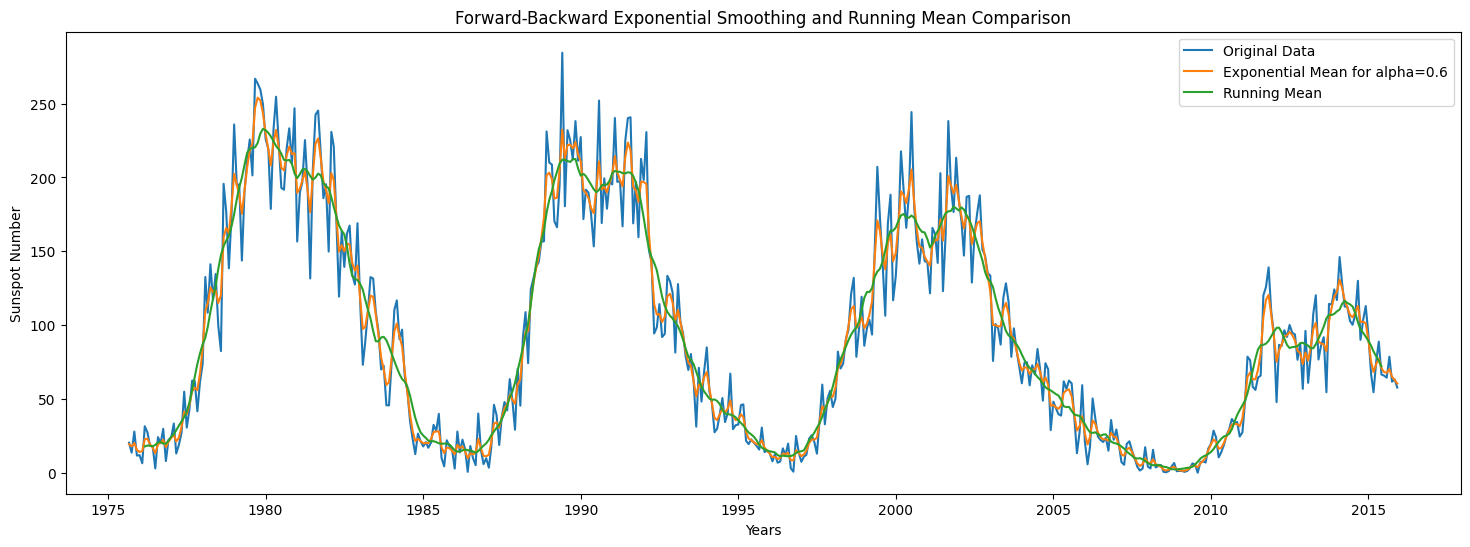

In [ ]:
alpha = 0.6000000000000001
plt.figure(figsize=(18, 6))
plt.plot(date, df["Monthly Mean Sunspot Number"], label="Original Data")
plt.plot(date, results[alpha]["Exponential mean"], label="Exponential Mean for alpha=0.6")
plt.plot(date, df["Monthly Mean Running Mean"], label="Running Mean")
plt.title("Forward-Backward Exponential Smoothing and Running Mean Comparison")
plt.xlabel("Years")
plt.ylabel("Sunspot Number")
plt.legend()
plt.show()

In [ ]:
deviation_indicator(df["Monthly Mean Sunspot Number"].to_numpy(),results[alpha]["Exponential mean"])

72679.44644042038

In [ ]:
variability_indicator(results[alpha]["Exponential mean"])

58863.55430728683

According to our assumption we now rely on a measurements data a bit more while preserving some small smoothing of the data.

## Part 2. 3d surface filtration using forward-backward smoothing.

1. Download surface data from Canvas, folder ‘Files/Week_1…/Assignment4/data /Surface/’
In the folder you will find two files:
- noisy_surface.txt (available measurements to work with)
- true_surface.txt (true surface to compare the estimation results)

In [ ]:
from google.colab import files
true = files.upload()
noise = files.upload()

Saving true_surface.txt to true_surface.txt


Saving noisy_surface.txt to noisy_surface.txt


2. Plot noisy and true surface for visualization purposes. To plot 3d surfaces in matlab, there is a command “mesh”. You can assign a colormap for the plot, i.e., “colormap jet”, “set(gca,'colormap','jet')” The plot should be accompanied with the “colorbar”.

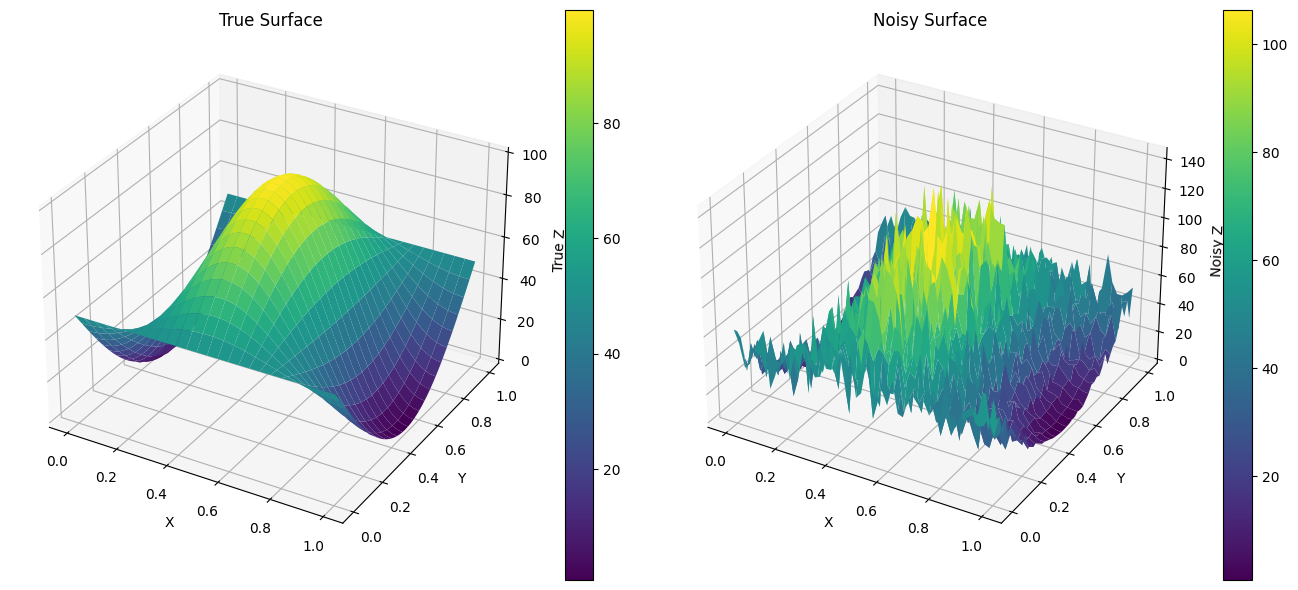

In [ ]:
def plot_3d(data, ax, name = 'Z'):
    size = int(np.sqrt(len(data)))

    x = np.linspace(0, 1, size)
    y = np.linspace(0, 1, size)

    X, Y = np.meshgrid(x, y)
    Z = data.reshape(X.shape)

    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel(name)
    fig.colorbar(surf, ax=ax)

with open("true_surface.txt", "r") as true_file:
    true_surface = np.array([float(x) for x in true_file.read().split()])

with open("noisy_surface.txt", 'r') as noisy_file:
    noisy_surface = np.array([float(x) for x in noisy_file.read().split()])

fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')

plot_3d(true_surface, ax1, 'True Z')
ax1.set_title('True Surface')

plot_3d(noisy_surface, ax2, 'Noisy Z')
ax2.set_title('Noisy Surface')
plt.tight_layout()
plt.show()


We can say that we have a two bell-shaped curves that form our surface and a very noisy measurements which forms second surface

3. Determine the variance of deviation of noisy surface from the true one. Hint: You may reshape the matrix (difference between the noisy and true surface) into one
array (“reshape command”) and then determine the variance of obtained array

In [ ]:
difference = noisy_surface - true_surface
variance = np.var(difference)

print(f"The variance of the deviation between the noisy and true surfaces is: {variance}")

The variance of the deviation between the noisy and true surfaces is: 120.57761955436905


4. Apply forward-backward exponential smoothing to filter noisy surface measurements. The smoothing constant can be α = 0.335
Hint: There should be 4 steps in forward-backward smoothing of a surface.

Step 1: Forward exponential smoothing of rows (from left to right).

Step 2: Backward exponential smoothing of results obtained at step 1 (from right to left).

Step 3: Forward exponential smoothing of results obtained at step 2 along the columns (from
bottom to top).

Step 4: Backward exponential smoothing of results obtained at step 3 along the columns (from top to bottom)

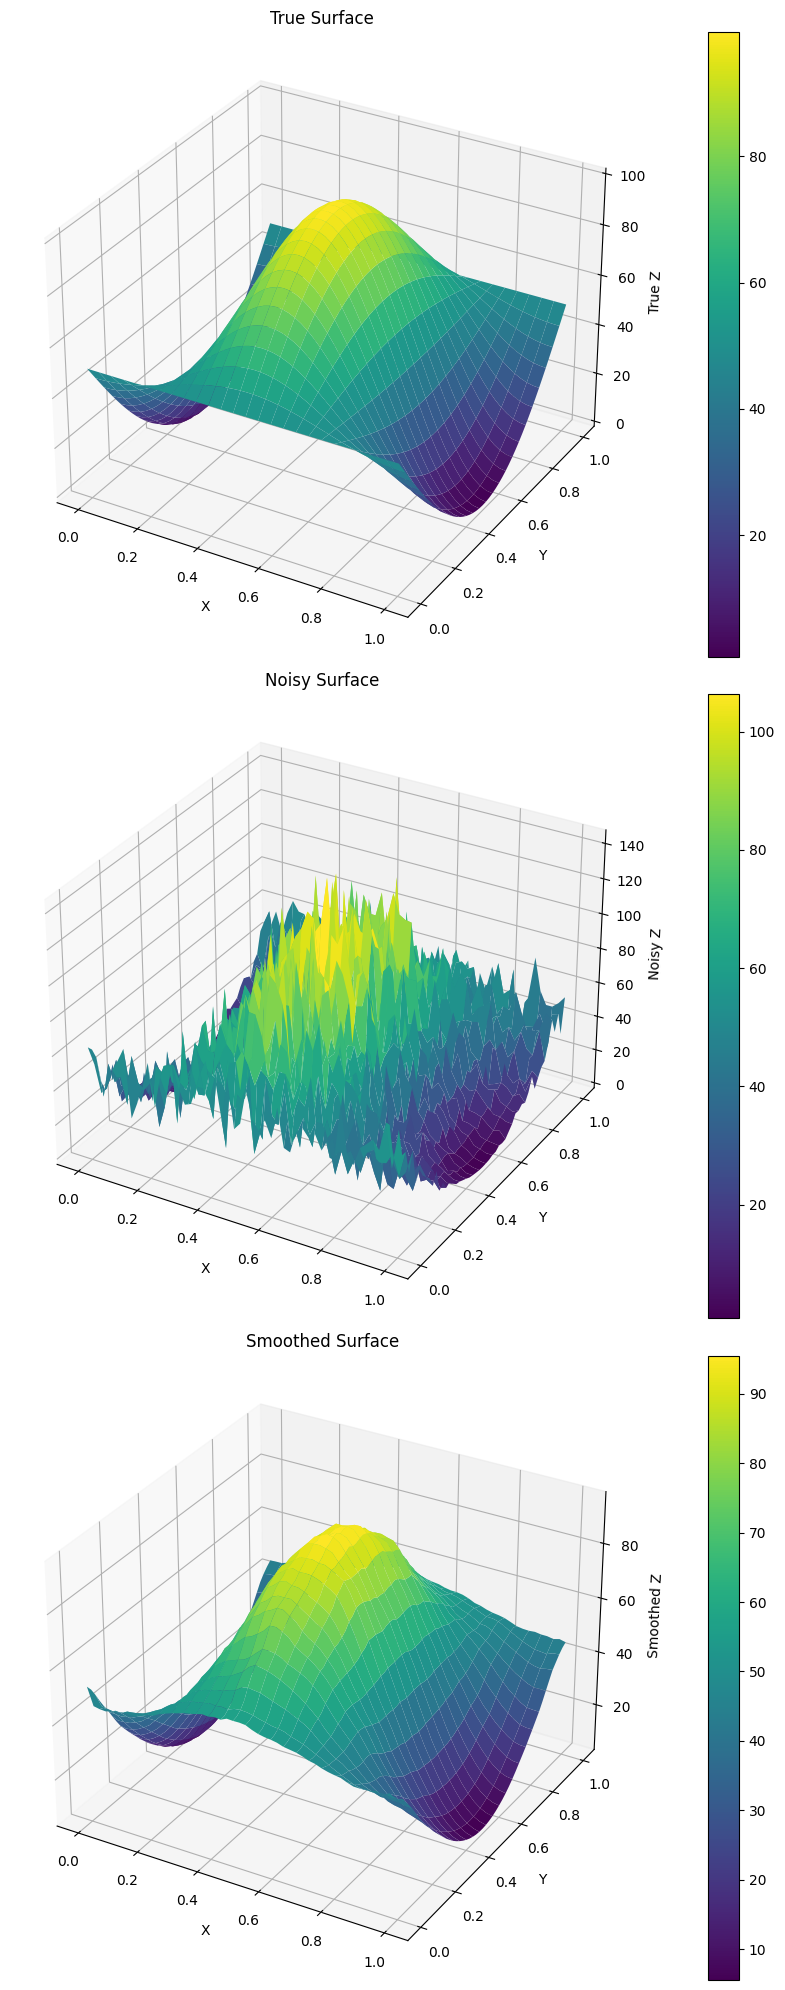

In [ ]:
alpha = 0.335

# Horizontal smoothing

# Step 1 and Step 2
smoothed_step2 = exponential_mean(noisy_surface, alpha, 'both')

# Vertical smoothing

# Making columns new rows to smooth
size = int(np.sqrt(len(smoothed_step2)))
smoothed_step2 = smoothed_step2.reshape(size, size)
smoothed_step2 = (smoothed_step2.T).reshape(-1)

# Step 3 and Step 4
smoothed_surface = exponential_mean(smoothed_step2, alpha, 'both')

# Transposing surface array back to normal
smoothed_surface = smoothed_surface.reshape(size, size)
smoothed_surface = smoothed_surface.T

x = np.linspace(0, 1, size)
y = np.linspace(0, 1, size)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(311, projection='3d')
ax2 = fig.add_subplot(312, projection='3d')
ax3 = fig.add_subplot(313, projection='3d')


plot_3d(true_surface, ax1, 'True Z')
ax1.set_title('True Surface')

plot_3d(noisy_surface, ax2, 'Noisy Z')
ax2.set_title('Noisy Surface')

plot_3d(smoothed_surface.reshape(-1), ax3, 'Smoothed Z')
ax3.set_title('Smoothed Surface')

plt.tight_layout()
plt.show()


As we can see we the smoothed surface is pretty close to the true one visually. And also we reduced the variance of surface deviation a lot. Let's show it:

In [ ]:
difference = smoothed_surface - true_surface.reshape(size, size)
difference = difference.reshape(-1)
variance = np.var(difference)
print(f"The variance of the deviation between the smoothed surface and the true surface is: {variance}")

The variance of the deviation between the smoothed surface and the true surface is: 7.33836171447458



7. Try greater and smaller values of smoothing coefficient α and explain the affect on estimation results.

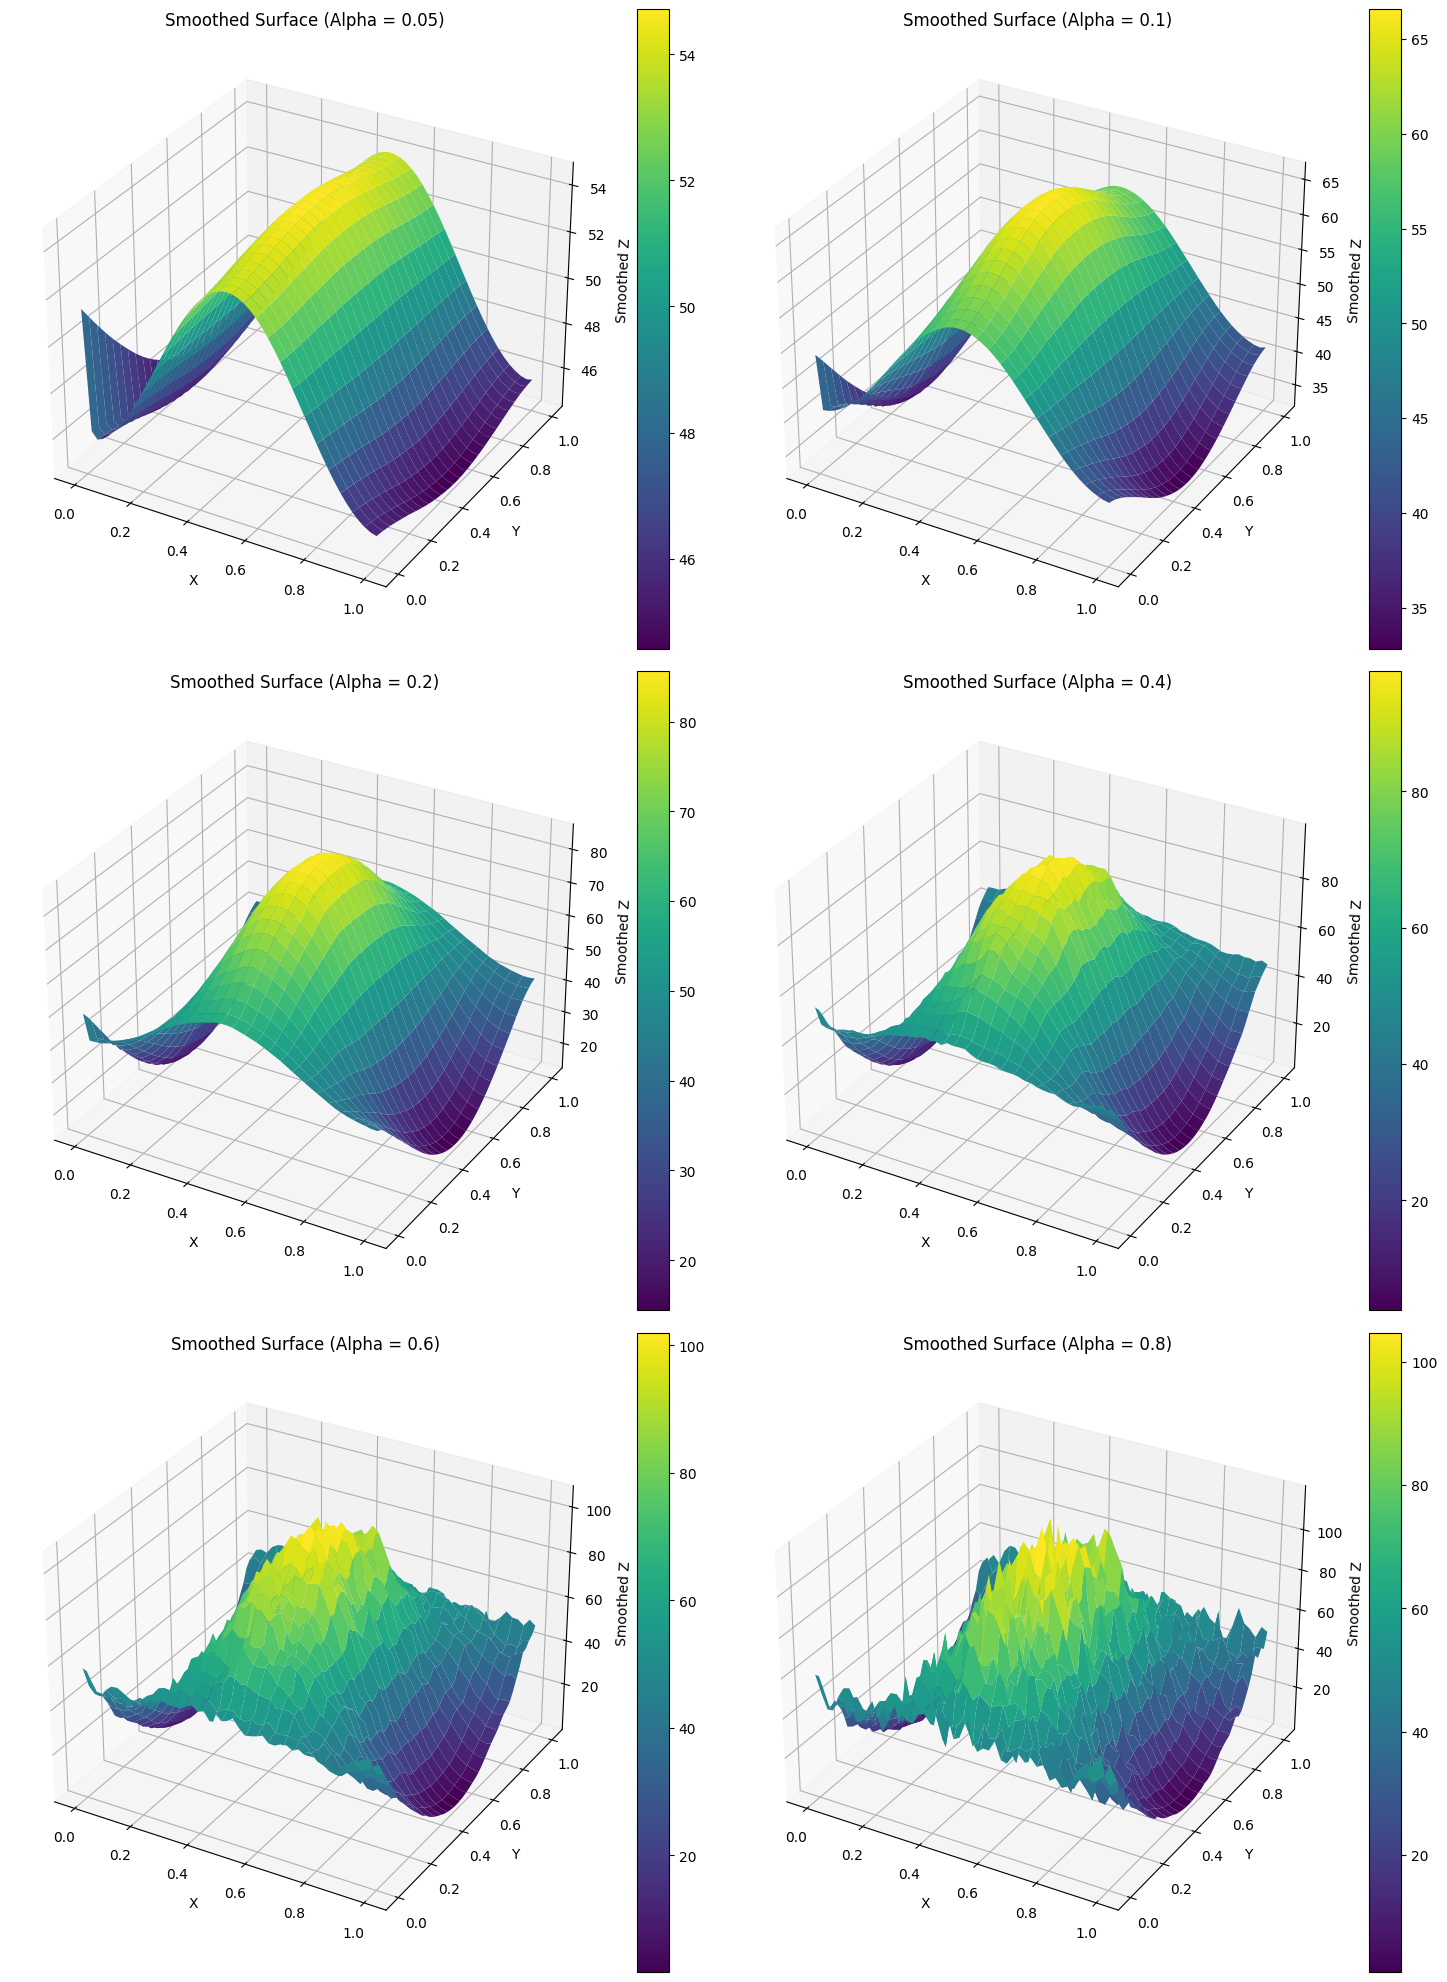

In [ ]:
alphas = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8]  # List of alpha values to try

fig = plt.figure(figsize=(15, 20))

for i, alpha in enumerate(alphas):
    # Horizontal smoothing

    # Step 1 and Step 2
    smoothed_step2 = exponential_mean(noisy_surface, alpha, 'both')

    # Vertical smoothing

    # Making columns new rows to smooth
    size = int(np.sqrt(len(smoothed_step2)))
    smoothed_step2 = smoothed_step2.reshape(size, size)
    smoothed_step2 = (smoothed_step2.T).reshape(-1)

    # Step 3 and Step 4
    smoothed_surface = exponential_mean(smoothed_step2, alpha, 'both')

    # Transposing surface array back to normal
    smoothed_surface = smoothed_surface.reshape(size, size)
    smoothed_surface = smoothed_surface.T

    x = np.linspace(0, 1, size)
    y = np.linspace(0, 1, size)
    X, Y = np.meshgrid(x, y)

    ax = fig.add_subplot(3, len(alphas)//3, i + 1, projection='3d')

    plot_3d(smoothed_surface.reshape(-1), ax, 'Smoothed Z')
    ax.set_title(f'Smoothed Surface (Alpha = {alpha})')



plt.tight_layout()
plt.show()


Basically we can explain this results by implying that we have two 1D curves. Now it becomes straightforward, we have two bell-shaped original data and very noisy measurements. High alpha coeffitient preserves noisy data because in this case we rely on measurements much more than on previous smoothed value and vice-versa for the smaller alpha case.

<b>Conclusion</b>: In this assignment we consolidated our knowledge that we should choose better coeffitients based on indicators only with the knowledge of the process itself. Otherwise we cannot interprent the acquired indicator values. Additionally we seen that we can smooth out 2d surfaces with